### Introduction

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by Bertelsmann Arvato Analytics, and was part of Udacity's Data Science Nanodegree program.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pickle

### Loading data, EDA

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [4]:
print(azdias.head())

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3  ...         NaN         NaN   
1                      4        

In [5]:
print(feat_info.tail())

      attribute information_level     type missing_or_unknown
80     PLZ8_HHZ    macrocell_plz8  ordinal               [-1]
81     PLZ8_GBZ    macrocell_plz8  ordinal               [-1]
82       ARBEIT         community  ordinal             [-1,9]
83  ORTSGR_KLS9         community  ordinal             [-1,0]
84     RELAT_AB         community  ordinal             [-1,9]


In [6]:
print(azdias.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
#inspect non-float or -int columns
print(azdias['CAMEO_DEUG_2015'].head(), '\n')
print(azdias['CAMEO_DEU_2015'].head(), '\n')
print(azdias['CAMEO_INTL_2015'].head(), '\n')

0    NaN
1      8
2      4
3      2
4      6
Name: CAMEO_DEUG_2015, dtype: object 

0    NaN
1     8A
2     4C
3     2A
4     6B
Name: CAMEO_DEU_2015, dtype: object 

0    NaN
1     51
2     24
3     12
4     43
Name: CAMEO_INTL_2015, dtype: object 



### Preprocessing
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We need to do a little bit of parsing to make use of it to identify and clean the data. Then we can convert the missing data column by column to make sure that all of the missing values get encoded as NaN values.

In [8]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
#list to save values to
to_save = []

for element in feat_info['missing_or_unknown']:
    #get rid of brackets
    element = element.replace('[', '').replace(']', '')
    
    #split on commas
    element = element.split(',')
    
    #if there are no misssing values, replace it with None
    if element == ['']:
        element = [None]
        
    to_save.append(element)

In [10]:
print(len(to_save))

85


In [11]:
print(to_save[:])

[['-1', '0'], ['-1', '0', '9'], ['-1', '0'], ['0'], ['-1'], ['-1'], ['-1'], ['-1'], ['-1'], ['-1'], ['-1'], ['0'], [None], [None], ['-1', '0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['-1', '0'], ['-1', '0'], ['0'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1', '9'], ['-1'], ['-1'], ['-1', '0'], ['-1'], ['-1', '9'], ['0'], [None], [None], ['-1', '0'], ['-1'], ['-1', '0'], ['-1', '0'], ['0'], [None], ['-1', '0'], [None], ['0'], ['-1'], ['-1'], ['-1', 'X'], ['XX'], ['-1', 'XX'], ['-1'], ['-1'], ['-1'], ['-1'], ['-1', '0'], ['-1', '0'], ['-1'], ['-1'], ['-1'], [None], ['-1', '0'], [None], [None], ['-1', '0'], [None], ['-1'], ['-1'], ['-1'], ['-1'], ['-1', '0'], ['-1'], ['-1'], ['-1', '9'], ['-1', '0'], ['-1', '9']]


So now we have a list of lists, each list containing the missing values that we can use for encoding. You can see that both integers and string values can represent a missing value, and that some columns do not have any missing values. Let's convert what values we can to integers.

In [12]:
#all of the possible ints in the above list
list_of_ints = ['-1', '0', '9']

for item in to_save:
    for i, element in enumerate(item):
        if element in list_of_ints:
            item[i] = int(element)

In [13]:
print(to_save[:])

[[-1, 0], [-1, 0, 9], [-1, 0], [0], [-1], [-1], [-1], [-1], [-1], [-1], [-1], [0], [None], [None], [-1, 0], [0], [0], [0], [0], [0], [0], [-1, 0], [-1, 0], [0], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1, 9], [-1], [-1], [-1, 0], [-1], [-1, 9], [0], [None], [None], [-1, 0], [-1], [-1, 0], [-1, 0], [0], [None], [-1, 0], [None], [0], [-1], [-1], [-1, 'X'], ['XX'], [-1, 'XX'], [-1], [-1], [-1], [-1], [-1, 0], [-1, 0], [-1], [-1], [-1], [None], [-1, 0], [None], [None], [-1, 0], [None], [-1], [-1], [-1], [-1], [-1, 0], [-1], [-1], [-1, 9], [-1, 0], [-1, 9]]


In [17]:
#save this list to file
#we will need it later for pre-processing the customer data
with open('to_save.txt', 'wb') as file:
    pickle.dump(to_save, file)

We can now use this list to replace missing values. We can also notice that either a column has no missing values, or it has missing values. This may sound trivial, but when we enumerate over our lists, if that list contains the value None then we can skip over it.

In [18]:
columns = azdias.columns

#iterate through corrected list
#iterator goes from 0-84 for 85 lists/columns
for i, item in enumerate(to_save):
    for element in item:
        #then there are no missing values
        if (element == None):
            continue
            
        #else there are missing values and we need to replace them
        else:
            #replace custom encoded values for each column in azdias
            azdias[columns[i]].replace(element, np.nan, inplace=True)

In [19]:
# Identify missing or unknown data values and convert them to NaNs.
missing = np.count_nonzero(azdias.isnull())
print('There are {} total missing values in this data set.'.format(missing))

There are 8373929 total missing values in this data set.


In [20]:
#total number of values possible in each column
total = azdias.shape[0]

#now let's look at how many missing values there are per column
#as a percentage of the total dataset
missing_per_column = azdias.isnull().sum() / total * 100.0

#and pring out the columns
print(missing_per_column)

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

### How much missing data is there in each colum?

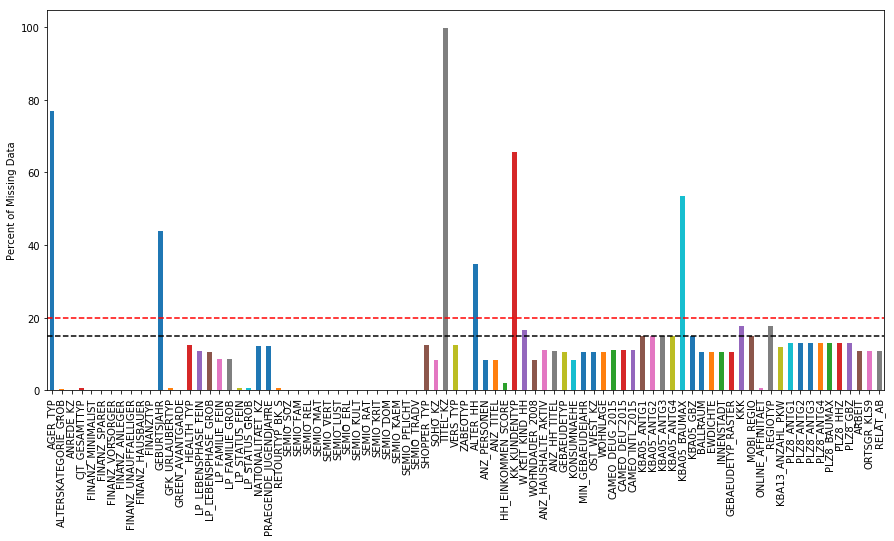

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#plot bar chart
missing_per_column.plot.bar(figsize=(15, 7))
plt.ylabel('Percent of Missing Data')

#plot different threshold values for missing data
plt.axhline(y=20, linestyle='--', color='r')
plt.axhline(y=15, linestyle='--', color='k')
plt.show()

In [18]:
# Investigate patterns in the amount of missing data in each column.
#so we have 61 out of 85 columns of our data that contain missing values
#how many of those 61 columns are missing more than 20% of their data? 10%?
missing30 = np.count_nonzero(missing_per_column>30)
missing20 = np.count_nonzero(missing_per_column>20)
missing10 = np.count_nonzero(missing_per_column>10)

print('There are {} columns missing more than 30% of their data.'.format(missing30), '\n')
print('There are {} columns missing more than 20% of their data.'.format(missing20), '\n')
print('There are {} columns missing more than 10% of their data.'.format(missing10), '\n')

There are 6 columns missing more than 30% of their data. 

There are 6 columns missing more than 20% of their data. 

There are 46 columns missing more than 10% of their data. 



I am going to make the cutoff at 30% of the data. Every column that has more missing data than that can be thrown out. You can see the difference between 10% and 20%: 40 columns! That means we can't be too strict in how much data we expect from each column, unless we want to lose more than half of our data set.

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
#find columns with large amounts of missing data
idx_to_drop = np.where(missing_per_column>30)[0].tolist()
columns_to_drop = columns[idx_to_drop]

In [20]:
print(idx_to_drop)
print(columns_to_drop)

[0, 11, 40, 43, 47, 64]
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


In [21]:
#drop those columns
azdias.drop(columns_to_drop, axis=1, inplace=True)

#also drop those labels as rows in our feature info dataframe
feat_info.drop(idx_to_drop, axis=0, inplace=True)

In [22]:
#we had 85 columns before, and dropped 9 columns
#so we should have 76 columns now
print(azdias.shape)
print(feat_info.shape)

(891221, 79)
(79, 4)


In [23]:
#see if columns to drop are still in dataframe
print([elem in azdias.columns for elem in columns_to_drop])

[False, False, False, False, False, False]


### Assess missing data in each column:

- 'AGER_TYP': best-ager typology 
- 'GEBURTSJAHR': year of birth
- 'TITEL_KZ': academic title flag
- 'ALTER_HH': birthdate of head of household
- 'KK_KUNDENTYP: consumer pattern over past 12 months
- 'W_KEIT_KIND_HH': likelihood of children in household
- 'KBA05_BAUMAX': most common building type within the microcell
- 'KKK': purchasing power in region
- 'REGIOTYP: neighborhood topology

It seem that the missing values come from two main camps of uncertainty. First, many of the columns stem from either direct or indirect uncertainty about someone's age. The direct columns are easy to spot, but things like purchasing power could be tied up in that.

Then there are columns with direct connections to uncertainty in the neighborhood or the housing complex.

What I thought was most interesting were the columns `'KK_KUNDENTYP'`, `'KKK'` and `'TITEL_KZ'`. Purchasing power in region, consumer behavior patterns, and academic title flag seem connected to me. These columns could be a mix of both the uncertainty due to age and the uncertainty due to housing conditions, or they could simply represent missing data. More would need to be known about how the data was collected.

### How much data is data in each row?

We can perform a similar assessment for the rows of the dataset. Then, depending on how much data is missing, we can divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In [24]:
# How much data is missing in each row of the dataset?
#total number of values possible in each row
rows, cols = azdias.shape

#now let's look at how many missing values there are per row
#as a percentage of the total dataset
missing_per_row = azdias.isnull().sum(axis=1) / cols * 100.0

#and pring out the row
print(missing_per_row)

0         54.430380
1          0.000000
2          0.000000
3          8.860759
4          0.000000
5          0.000000
6          0.000000
7          0.000000
8          0.000000
9          0.000000
10         0.000000
11        59.493671
12         7.594937
13        10.126582
14        59.493671
15        10.126582
16         7.594937
17        59.493671
18         3.797468
19         0.000000
20        12.658228
21         0.000000
22         0.000000
23        10.126582
24        59.493671
25         6.329114
26        24.050633
27         0.000000
28         0.000000
29         2.531646
            ...    
891191     0.000000
891192     0.000000
891193     0.000000
891194     0.000000
891195     0.000000
891196     0.000000
891197     0.000000
891198     0.000000
891199     0.000000
891200     0.000000
891201     0.000000
891202     0.000000
891203    17.721519
891204     0.000000
891205     0.000000
891206     0.000000
891207     0.000000
891208     3.797468
891209     0.000000


In [25]:
print(len(missing_per_row))

891221


We see that the data contains *rows* with lots of missing data, as before there were columns with a lot of missing values. Let's visualize the rows, and then pick a threshold to separate the data based on the amount of missing data.

In [26]:
mean_row_missing = np.mean(missing_per_row)
print(mean_row_missing)

7.15176430049


In [27]:
#amount of data not missing any values
not_missing = np.round((np.count_nonzero(missing_per_row == 0)  / rows * 100), 2)
missing_row = np.round((np.count_nonzero(missing_per_row < mean_row_missing)  / rows * 100), 2)

print('{}% of the data has no missing values.'.format(not_missing))
print('{}% of the data has missing values less than the overall row mean.'.format(missing_row))

69.93% of the data has no missing values.
80.75% of the data has missing values less than the overall row mean.


In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#create index to subset dataframe rows with
sub_idx = np.where(missing_per_row == 0)[0].tolist()
azdias_sub = azdias.copy().iloc[sub_idx, :]

#subset data for where there are many missing values
large_idx = np.where(missing_per_row > 0)[0].tolist()
azdias_many_missing = azdias.copy().iloc[large_idx, :]

In [29]:
print(len(sub_idx))
print(azdias_sub.shape)
print(azdias_many_missing.shape)

623209
(623209, 79)
(268012, 79)


In [30]:
#check to make sure data has been subset correctly, no duplicates
assert(azdias_sub.shape[0] == rows - azdias_many_missing.shape[0])

### Look at distributions of data with and without missing values.

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#input: two dataframe subsets of data, and a column
#output: show how those two dataframes compare based on the input column
def show_diff(df1, df2, col):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    
    sns.countplot(data=df1, x=col, ax=ax[0])
    ax[0].set_xlabel('Few missing values')
    
    sns.countplot(data=df2, x=col, ax=ax[1])
    ax[1].set_xlabel('Many missing values')
    
    title = "Count Plot for Column {} in Dataset".format(col)
    plt.suptitle(title, fontsize=16)
    
    plt.show()

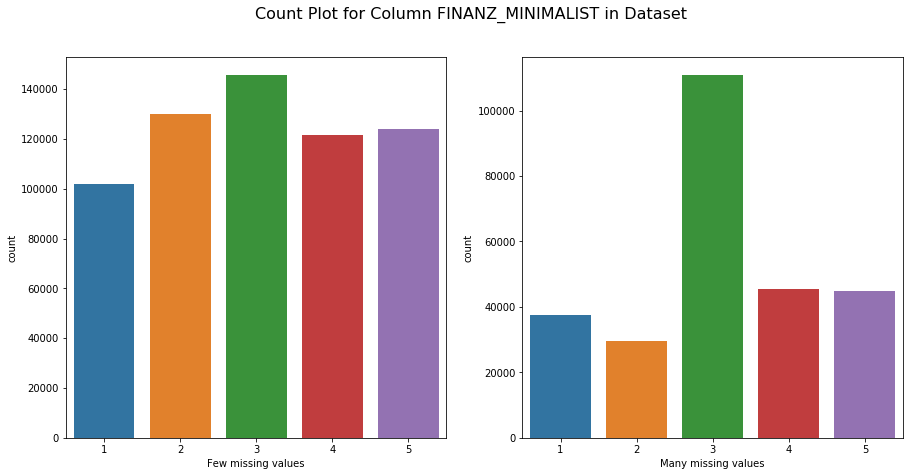

In [32]:
#let's look at a few columns and their respective distributions
show_diff(azdias_sub, azdias_many_missing, 'FINANZ_MINIMALIST')

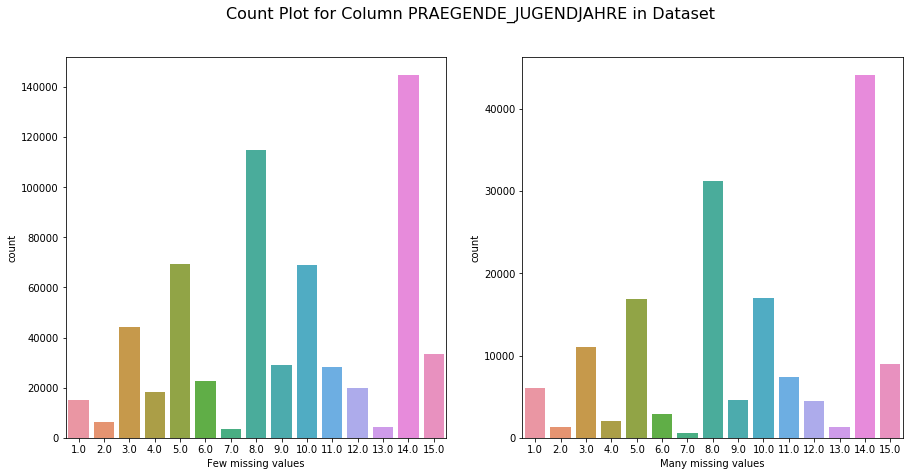

In [33]:
show_diff(azdias_sub, azdias_many_missing, 'PRAEGENDE_JUGENDJAHRE')

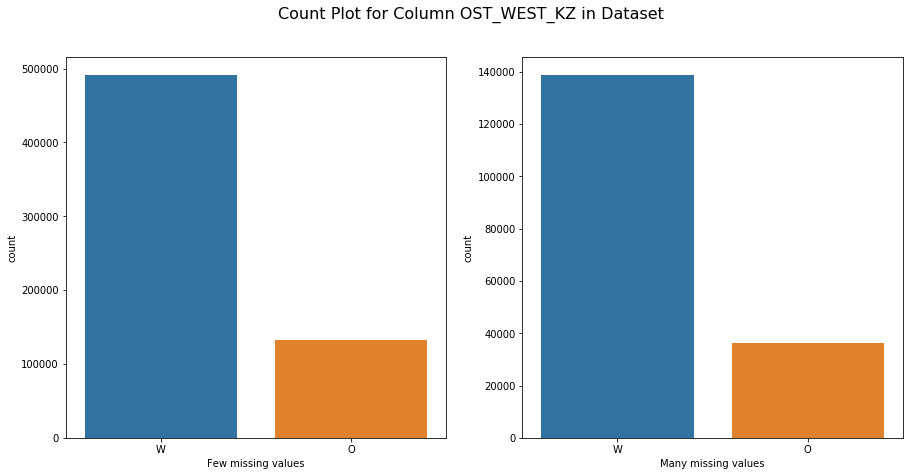

In [34]:
show_diff(azdias_sub, azdias_many_missing, 'OST_WEST_KZ')

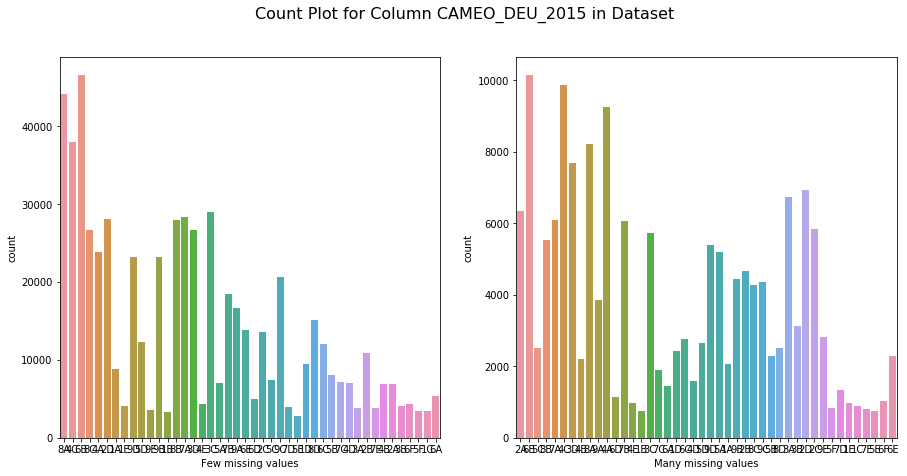

In [35]:
show_diff(azdias_sub, azdias_many_missing, 'CAMEO_DEU_2015')

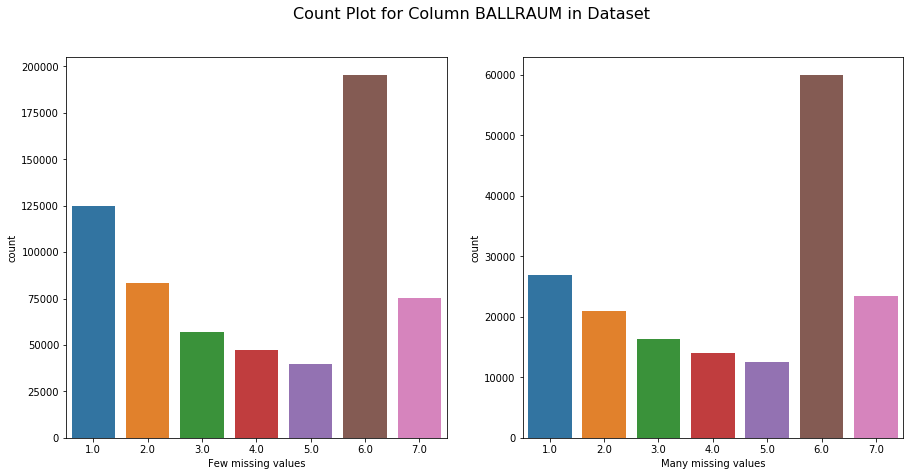

In [36]:
show_diff(azdias_sub, azdias_many_missing, 'BALLRAUM')

### Assess Missing Data in Each Row
The data can be separated into rows that have large amounts of missing data, and into a subset with relatively few missing data points. We can see that by comparing a few columns of the data, that there are some columns with very different distributions between the two subsets (look at `'FINANZ_MINIMALIST'` and `'CAMEO_DEU_2015'`, while other columns look almost identical.

Because we have a lot of data, I feel comfortable keeping only the rows with no missing data. This will also simplify pre-processing later, because scikit-learns's StandardScaler() assumes that we have no missing data (which we need to apply to our data before doing PCA).

### Select and Re-Encode Features

Since the clustering techniques we want to use will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In [37]:
# How many features are there of each data type?
print(feat_info.type.unique(), '\n')

num_cat = np.sum(feat_info.type == 'categorical')
num_mix = np.sum(feat_info.type == 'mixed')
num_both = num_cat + num_mix

print("There are {} columns of type 'categorical'.".format(num_cat))
print("There are {} columns of type 'mixed'.".format(num_mix), '\n')

print("So out of {} columns in our dataset, {} need to be encoded.".format(cols, num_both))

['ordinal' 'categorical' 'mixed' 'numeric'] 

There are 18 columns of type 'categorical'.
There are 6 columns of type 'mixed'. 

So out of 79 columns in our dataset, 24 need to be encoded.


### Categorical features

Let's encode the categorical data like so:
- For binary (two-level) categoricals that take numeric values, we can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), we can choose to encode the values using multiple dummy variables, or (to keep things straightforward) just drop them from the analysis. 

In [38]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
#redefine columns, because we dropped some before
subcolumns = azdias_sub.columns

#find the indices matching categorical and mixed type columns
cat_idx = np.where(feat_info.type == 'categorical')[0].tolist()
mix_idx = np.where(feat_info.type == 'mixed')[0].tolist()

#subset columns list for this indices
cat_cols = subcolumns[cat_idx]
mix_cols = subcolumns[mix_idx]

#subset our dataframe for these columns
azdias_cat = azdias_sub[cat_cols]
azdias_mix = azdias_sub[mix_cols]

In [39]:
unique_cat = []

for i, col in enumerate(azdias_cat.columns):
    to_append = list(azdias_cat[col].unique())
    unique_cat.append(to_append)
    
    print(i, col, to_append)

0 ANREDE_KZ [2, 1]
1 CJT_GESAMTTYP [5.0, 3.0, 2.0, 4.0, 1.0, 6.0]
2 FINANZTYP [1, 5, 2, 4, 6, 3]
3 GFK_URLAUBERTYP [10.0, 5.0, 1.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4.0, 7.0, 6.0, 2.0]
4 GREEN_AVANTGARDE [0, 1]
5 LP_FAMILIE_FEIN [5.0, 1.0, 10.0, 2.0, 7.0, 11.0, 8.0, 4.0, 6.0, 9.0, 3.0]
6 LP_FAMILIE_GROB [3.0, 1.0, 5.0, 2.0, 4.0]
7 LP_STATUS_FEIN [2.0, 3.0, 4.0, 1.0, 10.0, 9.0, 5.0, 6.0, 7.0, 8.0]
8 LP_STATUS_GROB [1.0, 2.0, 5.0, 4.0, 3.0]
9 NATIONALITAET_KZ [1.0, 2.0, 3.0]
10 SHOPPER_TYP [3.0, 2.0, 0.0, 1.0]
11 SOHO_KZ [1.0, 0.0]
12 VERS_TYP [2.0, 1.0]
13 ZABEOTYP [5, 4, 1, 6, 3, 2]
14 GEBAEUDETYP [8.0, 1.0, 3.0, 5.0]
15 OST_WEST_KZ ['W', 'O']
16 CAMEO_DEUG_2015 ['8', '4', '6', '2', '1', '9', '5', '7', '3']
17 CAMEO_DEU_2015 ['8A', '4C', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5D', '9E', '9B', '1B', '8B', '7A', '3D', '4E', '3C', '5A', '7B', '9A', '6E', '6D', '2C', '5C', '9C', '7D', '5E', '1D', '8D', '6C', '5B', '7C', '4D', '3A', '2B', '7E', '4B', '2A', '3B', '6F', '5F', '1C', '6A']


### Categorical features, discussion.
We can see right off the bat that one-hot encoding would increase our feature set by quite a few columns. We will need to convert `'OST_WEST_KZ'` to numeric columns, and `'CAMEO_DEU_2015'` seems like a more elaborate `'CAMEO_DEUG_2015'` column, so we will drop it for the sake of our analysis. The same can be said for `'LP_FAMILIE_FEIN'` and `'LP_FAMILIE_GROB'`, and then for `'LP_STATUS_FEIN'` and `'LP_STATUS_GROB'`, which are fine and rough scales of the same columns. We can keep the rough scale versions and drop the fine scales. That leaves 15 categorical columns to encode.

In [40]:
print(cat_cols)

Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'],
      dtype='object')


In [41]:
to_drop = ['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015']
azdias_sub.drop(to_drop, axis=1, inplace=True)

#update categorical columns for updating
cat_cols = [col for col in cat_cols if col not in to_drop]

#now we should have 73 columns
print(azdias_sub.shape)

(623209, 76)


In [42]:
#multi-level categorical features list
binary = []
ml_col = []

#make a copy of updated categorical dataframe
azdias_cat2 = azdias_cat.copy().drop(to_drop, axis=1)


for i, col in enumerate(azdias_cat2.columns):
    to_append = list(azdias_cat2[col].unique())
    
    #count length of unique features in column
    #if more than two, append to ml list
    if len(to_append) == 2:
        binary.append(col)
        
    if len(to_append) > 3:
        ml_col.append(col)
        print(i, col, to_append)

1 CJT_GESAMTTYP [5.0, 3.0, 2.0, 4.0, 1.0, 6.0]
2 FINANZTYP [1, 5, 2, 4, 6, 3]
3 GFK_URLAUBERTYP [10.0, 5.0, 1.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4.0, 7.0, 6.0, 2.0]
5 LP_FAMILIE_GROB [3.0, 1.0, 5.0, 2.0, 4.0]
6 LP_STATUS_GROB [1.0, 2.0, 5.0, 4.0, 3.0]
8 SHOPPER_TYP [3.0, 2.0, 0.0, 1.0]
11 ZABEOTYP [5, 4, 1, 6, 3, 2]
12 GEBAEUDETYP [8.0, 1.0, 3.0, 5.0]
14 CAMEO_DEUG_2015 ['8', '4', '6', '2', '1', '9', '5', '7', '3']


Let's pick a threshold value of 3 for how many unique values a categorical column can have before we drop it. I think keeping some of the columns is of value, but one hot encoding 4, 6, 9, or even 12 individual values per column will slow down our analysis.

In [43]:
# Re-encode categorical variable(s) to be kept in the analysis.

#one-hot encoding using pandas
#first process OST_WEST_KZ column, then drop the categorical column
azdias_sub = pd.concat([azdias_sub, pd.get_dummies(azdias_sub['OST_WEST_KZ'], prefix = 'OST_WEST_KZ')], axis=1)
azdias_sub.drop('OST_WEST_KZ', axis=1, inplace=True)
cat_cols = [col for col in cat_cols if col != 'OST_WEST_KZ']

In [44]:
print(ml_col)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']


In [45]:
#drop columns with more than 5 unique values
azdias_sub.drop(ml_col, axis=1, inplace=True)

#update categorical columns
cat_cols = [col for col in cat_cols if col not in binary]
cat_cols = [col for col in cat_cols if col not in ml_col]

print(cat_cols)

['NATIONALITAET_KZ']


In [46]:
azdias_sub.shape
len(cat_cols)

1

In [47]:
#get dummy variables for all of the rest of the categorical columns
for col in cat_cols:
    azdias_sub = pd.concat([azdias_sub, pd.get_dummies(azdias_sub[col], prefix=col)], axis=1)
    
azdias_sub.drop(cat_cols, axis=1, inplace=True)

In [48]:
print(azdias_sub.shape)

(623209, 70)


### Mixed-Type features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [49]:
print(mix_cols.values)

['LP_LEBENSPHASE_FEIN' 'LP_LEBENSPHASE_GROB' 'PRAEGENDE_JUGENDJAHRE'
 'WOHNLAGE' 'CAMEO_INTL_2015' 'PLZ8_BAUMAX']


In [50]:
decade_copy = azdias_sub['PRAEGENDE_JUGENDJAHRE'].copy()

#specify conditions
conditional_40 = decade_copy <= 2
conditional_50 = np.logical_and(decade_copy > 2, decade_copy <= 4)
conditional_60 = np.logical_and(decade_copy > 4, decade_copy <= 7)
conditional_70 = np.logical_and(decade_copy > 7, decade_copy <= 9)
conditional_80 = np.logical_and(decade_copy > 9, decade_copy <= 13)
conditional_90 = decade_copy > 13

decade_copy[conditional_40] = 40
decade_copy[conditional_50] = 50
decade_copy[conditional_60] = 60
decade_copy[conditional_70] = 70
decade_copy[conditional_80] = 80
decade_copy[conditional_90] = 90

In [51]:
print(decade_copy.unique())

[ 90.  70.  50.  80.  60.  40.]


In [52]:
#create new column here for decade
azdias_sub['PRAEGENDE_JUGENDJAHRE_decade'] = decade_copy

In [53]:
print(azdias_sub['PRAEGENDE_JUGENDJAHRE'].head())

1    14.0
2    15.0
4     8.0
5     3.0
6    10.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64


In [54]:
print(azdias_sub['PRAEGENDE_JUGENDJAHRE_decade'].head())

1    90.0
2    90.0
4    70.0
5    50.0
6    80.0
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: float64


In [55]:
#mainstream and avantgarde values, from Data_Dictionary.md
main_idx = [1, 3, 5, 8, 10, 12, 14]
avant_idx = [2, 4, 6, 7, 9, 11, 13, 15]

movement = azdias_sub['PRAEGENDE_JUGENDJAHRE'].copy()

#let's encode the movement to be 1 if mainstream, 0 if avantgarde
move = []

for value in movement:
    if value in main_idx:
        move.append(1)
    else:
        move.append(0)

In [56]:
#create new column for movement
azdias_sub['PRAEGENDE_JUGENDJAHRE_move'] = move

In [58]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#convert cameo_intl_2015 column into two columns
#one for the ten's place, the other for the one's place
azdias_sub['CAMEO_INTL_2015_tens'] = azdias_sub['CAMEO_INTL_2015'].copy().astype(int) // 10
azdias_sub['CAMEO_INTL_2015_ones'] = azdias_sub['CAMEO_INTL_2015'].copy().astype(int) % 10

In [59]:
#let's see these columns
print(azdias_sub[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_tens', 'CAMEO_INTL_2015_ones']].head())

  CAMEO_INTL_2015  CAMEO_INTL_2015_tens  CAMEO_INTL_2015_ones
1              51                     5                     1
2              24                     2                     4
4              43                     4                     3
5              54                     5                     4
6              22                     2                     2


`'LP_LEBENSPHASE_FEIN'` is the fine scale version of `'LP_LEBENSPHASE_GROB'` and includes 40 unique values. That is too many to one hot encode, especially since we can get a scaled down version of 12 different unique values in the rough scale feature. `'WOHNLAGE'` includes information about neighborhood quality, and only has 8 values to encode. I think that this information could be useful, so I am going to create dummy variables for this column. Lastly, we have `'PLZ8_BAUMAX'` that describes the most common building types in a neighborhood. This information is already contained in the other `'PLZ8_'` columns, so it too can be removed.

In [60]:
#get dummy variables for interesting mixed columns
mix_cols_keep = ['LP_LEBENSPHASE_GROB', 'WOHNLAGE']
for col in mix_cols_keep:
    azdias_sub = pd.concat([azdias_sub, pd.get_dummies(azdias_sub[col], prefix=col)], axis=1)

### Mixed-Type features, discussion.
After preprocessing the categorical columns, we have 2 new features from both `'PRAEGENDE_JUGENDJAHRE'` and `'CAMEO_INTL_2015'`. We then picked up 18 columns from processing `'LP_LEBENSPHASE_GROB'` and `'WOHNLAGE'`, but need to subtract 2 columns from `'LP_LEBENSPHASE_FEIN'` and `'PLZ8_BAUMAX'`. This brings the grand total to 88 columns, all of which are numeric and are either interval, ordinal, binary, or some other engineered feature.

In [61]:
#drop unnecessary mixed value columns
azdias_sub.drop(mix_cols, axis=1, inplace=True)

#update columns variable
columns = azdias_sub.columns

In [62]:
print(azdias_sub.shape)

(623209, 88)


In [70]:
#put all cleaning steps into one function
#this function assumes that we have acces to the to_save list prepared above
def clean_data(df, missing_values):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    columns = df.columns

    #iterate through missing values list
    for i, item in enumerate(missing_values):
        for element in item:
            #then there are no missing values
            if (element == None):
                continue
            
            #else there are missing values and we need to replace them
            else:
                #replace custom encoded values for each column in df
                df[columns[i]].replace(element, np.nan, inplace=True)
    
    
    #drop all unnecessary columns up front
    to_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
               'KBA05_BAUMAX', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 
               'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'ZABEOTYP', 'GEBAEUDETYP',
              'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'LP_FAMILIE_FEIN']

    
    for col in to_drop:
        df.drop(col, axis=1, inplace=True)

    #calculate row and columns
    rows, cols = df.shape
    missing_per_row = df.isnull().sum(axis=1) / cols * 100.0
    
    #only keep rows with less missing data data
    sub_idx = np.where(missing_per_row == 0)[0].tolist()
    df_sub = df.copy().iloc[sub_idx, :]
    
    
    #process OST_WEST_KZ column, then drop the categorical column
    df_sub = pd.concat([df_sub, pd.get_dummies(df_sub['OST_WEST_KZ'], prefix = 'OST_WEST_KZ')], axis=1)
    df_sub.drop('OST_WEST_KZ', axis=1, inplace=True)
    
    #get dummy variables for the rest of the categorical columns, leaving alone binary categorical columns
    cat_dummies = ['NATIONALITAET_KZ']
    
    for col in cat_dummies:
        df_sub = pd.concat([df_sub, pd.get_dummies(df_sub[col], prefix=col)], axis=1)
        df_sub.drop(col, axis=1, inplace=True)
    
    
    #now process mixed value columns
    mix_cols = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 
                'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
    
    
    decade_copy = df_sub['PRAEGENDE_JUGENDJAHRE'].copy()

    #specify conditions
    conditional_40 = decade_copy <= 2
    conditional_50 = np.logical_and(decade_copy > 2, decade_copy <= 4)
    conditional_60 = np.logical_and(decade_copy > 4, decade_copy <= 7)
    conditional_70 = np.logical_and(decade_copy > 7, decade_copy <= 9)
    conditional_80 = np.logical_and(decade_copy > 9, decade_copy <= 13)
    conditional_90 = decade_copy > 13

    decade_copy[conditional_40] = 40
    decade_copy[conditional_50] = 50
    decade_copy[conditional_60] = 60
    decade_copy[conditional_70] = 70
    decade_copy[conditional_80] = 80
    decade_copy[conditional_90] = 90

    #create new column here for decade
    df_sub['PRAEGENDE_JUGENDJAHRE_decade'] = decade_copy

    #mainstream and avantgarde values, from Data_Dictionary.md
    main_idx = [1, 3, 5, 8, 10, 12, 14]
    avant_idx = [2, 4, 6, 7, 9, 11, 13, 15]

    movement = df_sub['PRAEGENDE_JUGENDJAHRE'].copy()

    #let's encode the movement to be 1 if mainstream, 0 if avantgarde
    move = []

    for value in movement:
        if value in main_idx:
            move.append(1)
        else:
            move.append(0)

    #create new column for movement
    df_sub['PRAEGENDE_JUGENDJAHRE_move'] = move
    
        
    #convert cameo_intl_2015 column into two columns
    #one for the ten's place, the other for the one's place
    df_sub['CAMEO_INTL_2015_tens'] = df_sub['CAMEO_INTL_2015'].copy().astype(int) // 10
    df_sub['CAMEO_INTL_2015_ones'] = df_sub['CAMEO_INTL_2015'].copy().astype(int) % 10

    
    #get dummy variables for interesting mixed columns
    mix_cols_keep = ['LP_LEBENSPHASE_GROB', 'WOHNLAGE']
    
    for col in mix_cols_keep:
        df_sub = pd.concat([df_sub, pd.get_dummies(df_sub[col], prefix=col)], axis=1)

    for col in mix_cols:
        df_sub.drop(col, axis=1, inplace=True)
    
    #return the cleaned dataframe.
    return df_sub

In [71]:
#let's test the function we wrote
original = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

#clean the data
processed = clean_data(original)

#should have shape (623209, 88) to match our above processing steps
print(processed.shape)

(623209, 88)


Our data has the right shape, and has successfully been cleaned. We can now save this method to be used in the next Jupyter Notebook, `arvato_pca_clustering.ipynb`. We will see how Principal Component Analysis can be used to reduce the dimensionality of this large data set, and how clustering can then identify under- and overrepresented groups in our customer and demographic data.